In [1]:
import illustris_python as il
import matplotlib
#matplotlib.use('agg')# must call this before importing pyplot as plt:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import h5py
from astropy.cosmology import Planck15 as cosmo
import TraceSubhalos as ts

In [2]:
snapnumbers = [17,21,25,33,40,50,59,67,72,78,84]
redshifts = [5.,4.,3.,2.,1.5,1.,0.7,0.5,0.4,0.3,0.2]

zsnap = np.array(list(zip(np.array(snapnumbers), np.array(redshifts))))
#print(zsnap[:,0])

run = 'L35n2160TNG' #TNG50
basePath = '/n/holystore01/LABS/hernquist_lab/Lab/IllustrisTNG/Runs/L35n2160TNG/output/'
treePath = '/n/holystore01/LABS/hernquist_lab/Lab/IllustrisTNG/Runs/L35n2160TNG/postprocessing/trees/SubLink/'
treeFile = 'tree_extended.0.hdf5'
# hdf5 for getting redshifts basePath + '/snapdir_099/snap_099.0.hdf5'
#look under subhalo fields on the data description page for these
subhalofields = ['SubhaloMass', 'SubhaloSFR', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloHalfmassRad', 'SubhaloPos', 'SubhaloMassType', 'SubhaloMassInRadType', 'SubhaloMassInRadType', 'SubhaloSFRinHalfRad', 'SubhaloSFRinRad']


## old table directory path 
#/n/holystore01/LABS/hernquist_lab/Users/rnevin/AimeeTNG50project/Tables/

def GetTNGQuantities(redshift, fields = subhalofields):  #redshift is a float and fields is a list of strings
    snapnum = int(zsnap[np.where(zsnap[:,1] == redshift)][:,0])
    print(snapnum)
    Subfind_ID_mergers = np.loadtxt('/n/home09/aschechter/TNGProjects/merger_tables/' + str(snapnum) + '/all_mergers_at_' + str(snapnum) + '_enviro.txt', 
                            skiprows = 1, usecols = 1, dtype = int)
    
    Subfind_ID_nonmergers = np.loadtxt('/n/home09/aschechter/TNGProjects/merger_tables/' + str(snapnum) + '/nonmergers_matched_at_' + str(snapnum) + '_no_enviro.txt', 
                            skiprows = 1, usecols = 1, dtype = int)

    Type_mergers = np.loadtxt('/n/home09/aschechter/TNGProjects/merger_tables/' + str(snapnum) + '/all_mergers_at_' + str(snapnum) + '_enviro.txt', 
                            skiprows = 1, usecols = 4, dtype = str)
    
    Type_nonergers = np.loadtxt('/n/home09/aschechter/TNGProjects/merger_tables/' + str(snapnum) + '/nonmergers_matched_at_' + str(snapnum) + '_no_enviro.txt', 
                            skiprows = 1, usecols = 4, dtype = str)
    
    q = np.loadtxt('/n/home09/aschechter/TNGProjects/merger_tables/' + str(snapnum) + '/all_mergers_at_' + str(snapnum) + '_enviro.txt', 
                            skiprows = 1, usecols = 3, dtype = float)
    #print(qmergers)
    qmergers = []
    qnonmergers = np.zeros(len(Subfind_ID_nonmergers))
    
    for ratio in q:
        if ratio > 1:
            qmergers.append(1/ratio)
        else:
            qmergers.append(ratio)
    
    Subfind_ID = np.concatenate((Subfind_ID_mergers, Subfind_ID_nonmergers))
    Type = np.concatenate((Type_mergers, Type_nonergers))
    q = np.concatenate((qmergers, qnonmergers))
    
    QuantityTable = pd.DataFrame(data = Subfind_ID, columns = ['Subfind_ID'])
    QuantityTable['Type'] = Type
    
#ask Becky if mergers overlap between eg snap 49 and 50 in the tables
    #subhalos = il.groupcat.loadSubhalos(basePath,snapnum,fields=fields)
    #print('number of subhalos = ', subhalos['count'])
    
    #lists of stuff I want to plot
    
    totalgalaxymasses = []
    SFRs = []
    BHMasses = []
    BHARs = []
    Halfmassrads = []
    xPositions = []
    yPositions = []
    zPositions = []
    GasMasses = []
    StellarMassesTotal = []
    StellarMasses2halfrad = []
    GasMasses2halfrad = []
    SFRhalfrads = []
    SFR2halfrads = []
    
    
    for sID in Subfind_ID:
        subhalo_allfields = il.groupcat.loadSingle(basePath,snapnum,subhaloID=sID)
        totalmass = subhalo_allfields[fields[0]] * 1e10 / 0.704 # put in solar masses
        SFR = subhalo_allfields[fields[1]] #msun/yr
        BHMass = subhalo_allfields[fields[2]] * 1e10 / 0.704 #solar masses
        BHAR = subhalo_allfields[fields[3]] * (1e10 / 0.704) / (0.978e9 / 0.704)
        halfmasrad = subhalo_allfields[fields[4]] #ckpc/h
        xpos = subhalo_allfields[fields[5]][0]
        ypos = subhalo_allfields[fields[5]][1]
        zpos = subhalo_allfields[fields[5]][2]
        gasmass = subhalo_allfields[fields[6]][0] * 1e10
        stellarmasstotal = subhalo_allfields[fields[6]][4] * 1e10 / 0.704 # put in solar masses
        stellarmassin2halfrad = subhalo_allfields[fields[7]][4] * 1e10 / 0.704 # put in solar masses
        gasmassin2halfrad = subhalo_allfields[fields[7]][0] * 1e10 / 0.704 # put in solar masses
        SFRhalfrad = subhalo_allfields[fields[9]]
        SFR2halfrad = subhalo_allfields[fields[10]]
        
        totalgalaxymasses.append(totalmass)
        SFRs.append(SFR)
        BHMasses.append(BHMass)
        BHARs.append(BHAR)
        Halfmassrads.append(halfmasrad)
        xPositions.append(xpos)
        yPositions.append(ypos)
        zPositions.append(zpos)
        GasMasses.append(gasmass)
        StellarMassesTotal.append(stellarmasstotal)
        StellarMasses2halfrad.append(stellarmassin2halfrad)
        GasMasses2halfrad.append(gasmassin2halfrad)
        SFRhalfrads.append(SFRhalfrad)
        SFR2halfrads.append(SFR2halfrad)
        
    totalgalaxymasses = np.array(totalgalaxymasses)
    SFRs = np.array(SFRs)
    BHMasses = np.array(BHMasses)
    BHARs = np.array(BHARs)
    Halfmassrads = np.array(Halfmassrads)
    xPositions = np.array(xPositions)
    yPositions = np.array(yPositions)
    zPositions = np.array(zPositions)
    GasMasses = np.array(GasMasses)
    StellarMassesTotal = np.array(StellarMassesTotal)
    StellarMasses2halfrad = np.array(StellarMasses2halfrad)
    GasMasses2halfrad = np.array(GasMasses2halfrad)
    SFRhalfrads = np.array(SFRhalfrads)
    SFR2halfrads = np.array(SFR2halfrads)
    
    BaryonicMasses = GasMasses2halfrad + StellarMasses2halfrad
    GasFractions = GasMasses2halfrad/BaryonicMasses
    
    
    QuantityTable['TotalMass'] = totalgalaxymasses
    QuantityTable['SFR'] = SFRs
    QuantityTable['BHMass'] = BHMasses
    QuantityTable['BHAR'] = BHARs
    QuantityTable['Merger Mass Ratio'] = q
    QuantityTable['Half Mass Radius'] = Halfmassrads
    QuantityTable['x Position'] = xPositions
    QuantityTable['y Position'] = yPositions
    QuantityTable['z Position'] = zPositions
    QuantityTable['Gas Mass'] = GasMasses
    QuantityTable['Stellar Mass (2xhalfR)'] = StellarMasses2halfrad
    QuantityTable['Baryonic Mass'] = BaryonicMasses
    QuantityTable['Gas Fraction'] = GasFractions
    QuantityTable['SFR Halfmass Radius'] = SFRhalfrads
    QuantityTable['SFR 2 Halfmass Radius'] = SFR2halfrads
    
    return QuantityTable


In [3]:
QuantityTable = GetTNGQuantities(0.2,subhalofields)
MergerQuantities = QuantityTable.loc[QuantityTable['Type'] != '0.0']
NonMergerQuantities = QuantityTable.loc[QuantityTable['Type'] == '0.0']

84


In [4]:
CentralBinMergerQuantities = MergerQuantities.loc[MergerQuantities['Type'] == 'Merger']
CentralBinMergerQuantities

,Subfind_ID,Type,TotalMass,SFR,BHMass,BHAR,Merger Mass Ratio,Half Mass Radius,x Position,y Position,z Position,Gas Mass,Stellar Mass (2xhalfR),Baryonic Mass,Gas Fraction,SFR Halfmass Radius,SFR 2 Halfmass Radius
30,129693,Merger,5.013773e+09,6.776967,0.000000e+00,0.000000,0.679389,0.296283,17535.476562,34412.757812,28634.751953,1.039774e+09,2.585294e+09,3.083890e+09,0.161677,2.428984,4.901435
31,242148,Merger,2.325778e+09,1.549857,0.000000e+00,0.000000,0.224234,0.248381,16918.812500,20843.005859,22106.121094,3.579043e+08,1.336806e+09,1.604765e+09,0.166977,0.772476,1.360313
32,300739,Merger,3.800440e+09,18.052017,0.000000e+00,0.000000,0.681755,0.164057,9417.107422,25325.482422,17082.011719,9.339079e+08,1.945440e+09,2.313865e+09,0.159225,10.090291,15.306066
33,332766,Merger,5.998710e+11,3.597344,4.055717e+07,0.008795,0.192633,46.733429,24219.044922,26782.406250,23038.833984,4.991216e+10,1.799331e+10,2.642337e+10,0.319038,0.730986,1.983255
34,357527,Merger,3.536417e+09,1.940721,0.000000e+00,0.000000,0.475675,2.346987,32138.496094,18612.896484,34794.976562,1.829285e+09,7.428239e+08,2.769085e+09,0.731744,1.092980,1.599731
35,364612,Merger,1.070277e+10,8.953345,0.000000e+00,0.000000,0.435953,0.323220,7478.882812,8409.428711,2181.826172,9.535875e+08,7.711663e+09,8.440156e+09,0.086313,3.616231,7.439747
36,378743,Merger,2.511640e+12,4.867833,4.737495e+08,0.000422,0.102506,87.134125,23771.625000,23488.689453,4907.750977,1.377321e+11,8.330817e+10,8.545225e+10,0.025091,0.025497,0.313193
37,407385,Merger,7.332492e+08,0.317323,0.000000e+00,0.000000,0.961983,1.144440,1014.207703,26066.828125,23825.869141,3.880110e+08,1.601128e+08,6.363625e+08,0.748394,0.115149,0.286216
38,422493,Merger,1.162330e+09,0.547789,0.000000e+00,0.000000,0.408817,1.740371,3300.526611,19407.765625,13701.062500,7.310164e+08,1.108498e+08,9.963536e+08,0.888745,0.275767,0.491290
39,458019,Merger,3.412178e+11,1.985268,0.000000e+00,0.000000,0.814725,34.036827,7776.237793,34977.558594,24007.826172,2.278808e+10,9.957886e+09,2.159468e+10,0.538873,0.381824,1.805217


# Trace Single Subhalos

In [10]:
fields = ['FirstProgenitorID', 'NextProgenitorID', 'DescendantID', 'SubhaloSFR', 'SubfindID', 'SubhaloID', 'MainLeafProgenitorID', 'SubhaloMassType', 'SnapNum', 'TreeID']

In [11]:
ratio = 1./10.
for gal in CentralBinMergerQuantities['Subfind_ID'][3:4]:
    print('original subfind ID: ', gal)
    tree = il.sublink.loadTree(basePath,84,gal,fields=fields, onlyMPB=False)
    pprint(tree)
    numMergers = il.sublink.numMergers(tree,minMassRatio=ratio) #can add mass particle type if you want! (I think it automatically uses type = stars)
    pprint(numMergers)
    print('below is the tree ID')
    pprint(tree['TreeID'])
    print(np.where(tree['SnapNum']==83))

original subfind ID:  332766
{'DescendantID': array([147093903, 147093904, 147093905, ..., 147129843, 147129844,
       147093904]),
 'FirstProgenitorID': array([147093905, 147093906, 147093907, ..., 147129845,        -1,
              -1]),
 'MainLeafProgenitorID': array([147093987, 147093987, 147093987, ..., 147129845, 147129845,
       147129846]),
 'NextProgenitorID': array([147129847, 147121250, 147120977, ...,        -1,        -1,
              -1]),
 'SnapNum': array([84, 83, 82, ..., 68, 66, 83], dtype=int16),
 'SubfindID': array([332766, 326686, 356250, ..., 449252, 443126, 326723], dtype=int32),
 'SubhaloID': array([147093904, 147093905, 147093906, ..., 147129844, 147129845,
       147129846]),
 'SubhaloMassType': array([[4.9912157e+00, 3.5526760e+01, 0.0000000e+00, 0.0000000e+00,
        1.7100881e+00, 2.8552250e-03],
       [5.1467319e+00, 3.7234924e+01, 0.0000000e+00, 0.0000000e+00,
        1.5695622e+00, 1.8724060e-03],
       [4.9653192e+00, 3.5809658e+01, 0.0000000e+00

In [12]:
f = h5py.File(treePath + treeFile, 'r')
list(f.keys())

['DescendantID',
 'FirstProgenitorID',
 'FirstSubhaloInFOFGroupID',
 'GroupBHMass',
 'GroupBHMdot',
 'GroupCM',
 'GroupFirstSub',
 'GroupGasMetalFractions',
 'GroupGasMetallicity',
 'GroupLen',
 'GroupLenType',
 'GroupMass',
 'GroupMassType',
 'GroupNsubs',
 'GroupPos',
 'GroupSFR',
 'GroupStarMetalFractions',
 'GroupStarMetallicity',
 'GroupVel',
 'GroupWindMass',
 'Group_M_Crit200',
 'Group_M_Crit500',
 'Group_M_Mean200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_Crit500',
 'Group_R_Mean200',
 'Group_R_TopHat200',
 'LastProgenitorID',
 'MainLeafProgenitorID',
 'Mass',
 'MassHistory',
 'NextProgenitorID',
 'NextSubhaloInFOFGroupID',
 'NumParticles',
 'RootDescendantID',
 'SnapNum',
 'SubfindID',
 'SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloCM',
 'SubhaloGasMetalFractions',
 'SubhaloGasMetalFractionsHalfRad',
 'SubhaloGasMetalFractionsMaxRad',
 'SubhaloGasMetalFractionsSfr',
 'SubhaloGasMetalFractionsSfrWeighted',
 'SubhaloGasMetallicity',
 'SubhaloGasMetallicityHalfRad',
 'S

In [13]:
subFIND = f['SubfindID']
print(subFIND.shape)
print(subFIND.dtype)

(218540221,)
int32


In [14]:
for num in [59854358, 59854359, 59854358]:
    print(f['SnapNum'][num])

84
82
84


In [15]:
ratio = 1./10.
for gal in CentralBinMergerQuantities['Subfind_ID'][2:3]:
    progenitors = []
    descendants = []
    faileddescendants = []
    print('original subfind ID: ', gal)
    tree = il.sublink.loadTree(basePath,84,gal,fields=fields, onlyMPB=False)
    #pprint(tree)
    numMergers = il.sublink.numMergers(tree,minMassRatio=ratio)
    pprint(numMergers)
    bigfile = h5py.File(basePath + '/snapdir_084/snap_084.0.hdf5', 'r')
    z_header = bigfile['Header'].attrs['Redshift']
    t0 = cosmo.age(z_header) 
    if tree['TreeID'].any() != 0:
        print('THIS SUBHALO NOT IN TREE 0', tree['TreeID'])
    
    else:
    
        for fp in tree['FirstProgenitorID']:
            if f['SnapNum'][fp] == 83:
                #how to get redshifts of any snapshot in order to get lookback time for merger plots
                bigfile = h5py.File(basePath + '/snapdir_083/snap_083.0.hdf5', 'r')
                z_header = bigfile['Header'].attrs['Redshift']
                age = cosmo.age(z_header) 
                progenitors.append([f['SubfindID'][fp], 83, age])
            elif f['SnapNum'][fp] == 82:
                bigfile = h5py.File(basePath + '/snapdir_082/snap_082.0.hdf5', 'r')
                z_header = bigfile['Header'].attrs['Redshift']
                age = cosmo.age(z_header) 
                progenitors.append([f['SubfindID'][fp], 82, age])

        for np in tree['NextProgenitorID']:
            if f['SnapNum'][np] == 83:
                bigfile = h5py.File(basePath + '/snapdir_083/snap_083.0.hdf5', 'r')
                z_header = bigfile['Header'].attrs['Redshift']
                age = cosmo.age(z_header) 
                progenitors.append([f['SubfindID'][np], 83, age])
            elif f['SnapNum'][np] == 82:
                bigfile = h5py.File(basePath + '/snapdir_082/snap_082.0.hdf5', 'r')
                z_header = bigfile['Header'].attrs['Redshift']
                age = cosmo.age(z_header) 
                progenitors.append([f['SubfindID'][np], 82, age])

        for d in tree['DescendantID']:
            if f['SnapNum'][d] == 85:
                descendants.append([f['SubfindID'][d], 85])
            elif f['SnapNum'][d] == 86:
                descendants.append([f['SubfindID'][d], 86])
            
            else: 
                faileddescendants.append(f['SnapNum'][d])

        print(progenitors)
        print(descendants)
        #print(faileddescendants)

original subfind ID:  300739
1
[[294415, 83, <Quantity 11.13250945 Gyr>], [294497, 82, <Quantity 11.01027755 Gyr>]]
[[306882, 85]]


In [16]:
descendants[0]

[306882, 85]

In [17]:
#find descendent in snap 86
descID = descendants[0][0]
tree = il.sublink.loadTree(basePath,85,descID,fields=fields, onlyMDB=True)
if tree['TreeID'].any() != 0:
        print('THIS SUBHALO NOT IN TREE 0', tree['TreeID'])
    
else:
    for d in tree['DescendantID']:
        if f['SnapNum'][d] == 86:
            bigfile = h5py.File(basePath + '/snapdir_086/snap_086.0.hdf5', 'r')
            z_header = bigfile['Header'].attrs['Redshift']
            age = cosmo.age(z_header) 
            descendants.append([f['SubfindID'][d], age])
        elif f['SnapNum'][d] == 87:
            bigfile = h5py.File(basePath + '/snapdir_087/snap_087.0.hdf5', 'r')
            z_header = bigfile['Header'].attrs['Redshift']
            age = cosmo.age(z_header) 
            descendants.append([f['SubfindID'][d], age])
            
        else: 
            faileddescendants.append(f['SnapNum'][d])

In [18]:
print(descendants)

[[306882, 85], [313280, <Quantity 11.81844014 Gyr>], [309292, <Quantity 11.62911467 Gyr>], [309292, <Quantity 11.62911467 Gyr>]]


In [19]:
progenitors[0][1]

83

In [20]:
print(CentralBinMergerQuantities['TotalMass'][3:4])
subhalo_allfields = il.groupcat.loadSingle(basePath,progenitors[0][1],subhaloID=progenitors[0][0])
totalmass = subhalo_allfields['SubhaloMass'] * 1e10 / 0.704
print(totalmass)

print(totalmass/CentralBinMergerQuantities['TotalMass'][2:3])

33    5.998710e+11
Name: TotalMass, dtype: float64
2198556480.4212613
32    0.578501
Name: TotalMass, dtype: float64


/n/home09/aschechter/.conda/envs/mypy/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


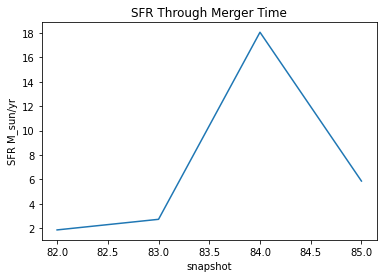

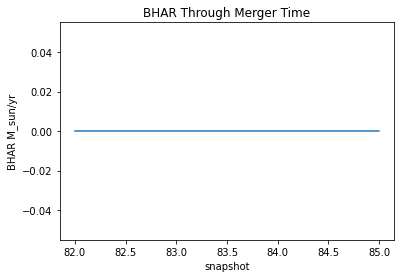

In [21]:
SFR1 = il.groupcat.loadSingle(basePath,progenitors[1][1],subhaloID=progenitors[1][0])['SubhaloSFR']
SFR2 = il.groupcat.loadSingle(basePath,progenitors[0][1],subhaloID=progenitors[0][0])['SubhaloSFR']
SFR3 = CentralBinMergerQuantities['SFR'][2:3]
SFR4 = il.groupcat.loadSingle(basePath,descendants[0][1],subhaloID=descendants[0][0])['SubhaloSFR']

plt.figure()
plt.title('SFR Through Merger Time')
plt.plot([82,83,84,85], [SFR1, SFR2, SFR3, SFR4])
plt.xlabel('snapshot')
plt.ylabel('SFR M_sun/yr')
plt.savefig('SFRtime_z02.png', dpi = 300)
plt.show()

BHAR1 = il.groupcat.loadSingle(basePath,progenitors[1][1],subhaloID=progenitors[1][0])['SubhaloBHMdot']
BHAR2 = il.groupcat.loadSingle(basePath,progenitors[0][1],subhaloID=progenitors[0][0])['SubhaloBHMdot']
BHAR3 = CentralBinMergerQuantities['BHAR'][2:3]
BHAR4 = il.groupcat.loadSingle(basePath,descendants[0][1],subhaloID=descendants[0][0])['SubhaloBHMdot']

plt.figure()
plt.title('BHAR Through Merger Time')
plt.plot([82,83,84,85], [BHAR1, BHAR2, BHAR3, BHAR4])
plt.xlabel('snapshot')
plt.ylabel('BHAR M_sun/yr')
plt.show()

In [22]:
ratio = 1./10.

tree = il.sublink.loadTree(basePath,85,163036863,fields=fields, onlyMPB=False)
pprint(tree)
numMergers = il.sublink.numMergers(tree,minMassRatio=ratio)
pprint(numMergers)

IndexError: Index (163036863) out of range for (0-5883278)

In [ ]:
for gal in [242148, 253918, 251614, 242421, 238818, 251628, 226787, 242428]:
    subhalo_allfields = il.groupcat.loadSingle(basePath,84,subhaloID=gal)
    stellarmasstotal = subhalo_allfields['SubhaloMassType'][4] * 1e10 / 0.704 # put in solar masses
    print(stellarmasstotal)

1816518012.0955815
0.0
0.0
1014292.9857631151
0.0
152355.28394441644
37120.884144314914
47840.21905896391


In [ ]:
#how to get redshifts of any snapshot in order to get lookback time for merger plots
f = h5py.File(basePath + '/snapdir_099/snap_099.0.hdf5', 'r')
list(f.keys())
print(f['Header'].attrs['Redshift'])
z_header = f['Header'].attrs['Redshift']
age = cosmo.age(z_header) 
print(age) 

2.220446049250313e-16
13.797615896896383 Gyr


# Debug Tree Error

In [21]:
import TraceSubhalos as ts
#firstprogenitors, nextprogenitors, descendants, faileddescendants, t0 = ts.FollowSingleSubhalo(332766, 84)

In [5]:
difftree = []
for gal in CentralBinMergerQuantities['Subfind_ID']:
    output = ts.FollowSingleSubhalo(gal, 84, 0)
    if np.shape(output) == (1,):
        difftree.append(gal)
    

Tree ID [0 0 0 0]
this works
Tree ID [0 0 0 0 0 0 0 0]
this works
Tree ID [0 0 0 0]
this works
Tree ID [0 0 0 ... 0 0 0]
this works


/n/home09/aschechter/.conda/envs/mypy/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Tree ID [10000001800000000 10000001800000000 10000001800000000 10000001800000000]
THIS SUBHALO NOT IN TREE 0  [10000001800000000 10000001800000000 10000001800000000 10000001800000000]
Tree ID [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
this works
Tree ID [0 0 0 ... 0 0 0]
this works
Tree ID [0 0 0]
this works
Tree ID [0 0 0]
this works
Tree ID [10000003300000000 10000003300000000 10000003300000000 ...
 10000003300000000 10000003300000000 10000003300000000]
THIS SUBHALO NOT IN TREE 0  [10000003300000000 10000003300000000 10000003300000000 ...
 10000003300000000 10000003300000000 10000003300000000]
Tree ID [0 0 0 ... 0 0 0]
this works
Tree ID [0 0 0]
this works
Tree ID [0 0 0 ... 0 0 0]
this works
Tree ID [20000005100000000 20000005100000000 20000005100000000 20000005100000000
 20000005100000000 20000005100000000 20000005100000000 20000005100000000
 20000005100000000 20000005100000000]
THIS SUBHALO NOT IN TREE 0  [20000005100000000 20000005100000000 20000005100000000 20000005100000000
 200

In [6]:
difftree2 = []
for gal in difftree:
    ts.FollowSingleSubhalo(gal, 84, 1)


Tree ID [10000001800000000 10000001800000000 10000001800000000 10000001800000000]
this works


IndexError: Index (10000001800223871) out of range for (0-43669108)

In [ ]:
print(np.shape(difftree2))

(0,)
